# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 42.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning).

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [15]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [8]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [9]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [16]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6371
F1-Score: 0.4597
Epoch 00002 | Loss: 0.5818
Epoch 00003 | Loss: 0.5626
Epoch 00004 | Loss: 0.5566
Epoch 00005 | Loss: 0.5518
Epoch 00006 | Loss: 0.5463
F1-Score: 0.4893
Epoch 00007 | Loss: 0.5418
Epoch 00008 | Loss: 0.5377
Epoch 00009 | Loss: 0.5342
Epoch 00010 | Loss: 0.5315
Epoch 00011 | Loss: 0.5287
F1-Score: 0.5274
Epoch 00012 | Loss: 0.5258
Epoch 00013 | Loss: 0.5231
Epoch 00014 | Loss: 0.5207
Epoch 00015 | Loss: 0.5184
Epoch 00016 | Loss: 0.5162
F1-Score: 0.5377
Epoch 00017 | Loss: 0.5140
Epoch 00018 | Loss: 0.5120
Epoch 00019 | Loss: 0.5101
Epoch 00020 | Loss: 0.5084
Epoch 00021 | Loss: 0.5068
F1-Score: 0.5066
Epoch 00022 | Loss: 0.5051
Epoch 00023 | Loss: 0.5022
Epoch 00024 | Loss: 0.5005
Epoch 00025 | Loss: 0.4984
Epoch 00026 | Loss: 0.4964
F1-Score: 0.5364
Epoch 00027 | Loss: 0.4939
Epoch 00028 | Loss: 0.4918
Epoch 00029 | Loss: 0.4896
Epoch 00030 | Loss: 0.4880
Epoch 00031 | Loss: 0.4862
F1-Score: 0.5463
Epoch 00032 | Loss: 0.4847
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6549


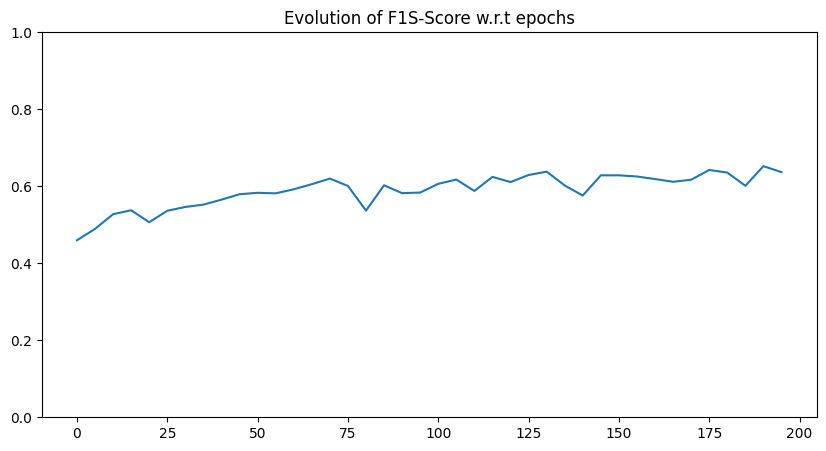

In [17]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

#GAT Transductive Learning Model (As thesis purposed)

In [6]:
from torch_geometric.nn import GATConv

In [ ]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()

      ####### YOUR ANSWER #######
      # Define the first Graph Attention layer
      self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads=8, dropout=0.6)
      # Define the second Graph Attention layer
      self.gatconv2 = graphnn.GATConv(8*hidden_size, hidden_size, heads=8, concat=False, dropout=0.6)
      # Linear layer for multi-label classification
      self.linear = nn.Linear(hidden_size, output_size)

      self.elu = nn.ELU()
      self.sigmoid = nn.Sigmoid()

  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.gatconv1(x, edge_index)
      x = self.elu(x)
      x = self.gatconv2(x, edge_index)
      x = self.elu(x)
      x = self.linear(x)
      return x

Let's train your model !

In [ ]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5937
F1-Score: 0.4149
Epoch 00002 | Loss: 0.5391
Epoch 00003 | Loss: 0.5270
Epoch 00004 | Loss: 0.5167
Epoch 00005 | Loss: 0.5117
Epoch 00006 | Loss: 0.5062
F1-Score: 0.4747
Epoch 00007 | Loss: 0.4993
Epoch 00008 | Loss: 0.4993
Epoch 00009 | Loss: 0.4990
Epoch 00010 | Loss: 0.4927
Epoch 00011 | Loss: 0.4877
F1-Score: 0.5552
Epoch 00012 | Loss: 0.4848
Epoch 00013 | Loss: 0.4836
Epoch 00014 | Loss: 0.4805
Epoch 00015 | Loss: 0.4801
Epoch 00016 | Loss: 0.4780
F1-Score: 0.5742
Epoch 00017 | Loss: 0.4754
Epoch 00018 | Loss: 0.4734
Epoch 00019 | Loss: 0.4698
Epoch 00020 | Loss: 0.4680
Epoch 00021 | Loss: 0.4665
F1-Score: 0.6047
Epoch 00022 | Loss: 0.4642
Epoch 00023 | Loss: 0.4628
Epoch 00024 | Loss: 0.4597
Epoch 00025 | Loss: 0.4584
Epoch 00026 | Loss: 0.4539
F1-Score: 0.6133
Epoch 00027 | Loss: 0.4518
Epoch 00028 | Loss: 0.4517
Epoch 00029 | Loss: 0.4510
Epoch 00030 | Loss: 0.4492
Epoch 00031 | Loss: 0.4450
F1-Score: 0.6213
Epoch 00032 | Loss: 0.4432
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.7169


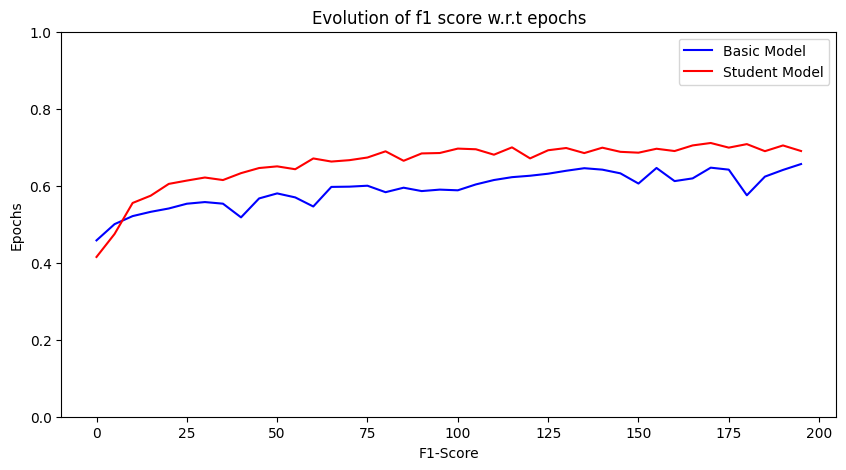

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

#GAT Inductive Learning Model (Without using Sigmoid)

In [4]:
class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        # GAT layers
        self.gat1 = GATConv(input_size, hidden_size, heads=6, concat=True)
        self.gat2 = GATConv(hidden_size * 6, hidden_size, heads=6, concat=True)
        self.gat3 = GATConv(hidden_size * 6, output_size, heads=4, concat=False)

        # Activation
        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        # First GAT layer
        x = self.elu(self.gat1(x, edge_index))
        x_skip = x.clone()
        # Second GAT layer
        x = self.elu(self.gat2(x, edge_index))
        # Third GAT layer for classification
        x = x + x_skip
        x = self.gat3(x, edge_index)
        return x

In [ ]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5952
F1-Score: 0.3674
Epoch 00002 | Loss: 0.5561
Epoch 00003 | Loss: 0.5477
Epoch 00004 | Loss: 0.5365
Epoch 00005 | Loss: 0.5251
Epoch 00006 | Loss: 0.5132
F1-Score: 0.4761
Epoch 00007 | Loss: 0.5017
Epoch 00008 | Loss: 0.4910
Epoch 00009 | Loss: 0.4819
Epoch 00010 | Loss: 0.4726
Epoch 00011 | Loss: 0.4654
F1-Score: 0.5835
Epoch 00012 | Loss: 0.4572
Epoch 00013 | Loss: 0.4466
Epoch 00014 | Loss: 0.4357
Epoch 00015 | Loss: 0.4266
Epoch 00016 | Loss: 0.4207
F1-Score: 0.6313
Epoch 00017 | Loss: 0.4110
Epoch 00018 | Loss: 0.3998
Epoch 00019 | Loss: 0.3884
Epoch 00020 | Loss: 0.3768
Epoch 00021 | Loss: 0.3667
F1-Score: 0.6818
Epoch 00022 | Loss: 0.3559
Epoch 00023 | Loss: 0.3613
Epoch 00024 | Loss: 0.3490
Epoch 00025 | Loss: 0.3340
Epoch 00026 | Loss: 0.3241
F1-Score: 0.7283
Epoch 00027 | Loss: 0.3174
Epoch 00028 | Loss: 0.3136
Epoch 00029 | Loss: 0.3174
Epoch 00030 | Loss: 0.3144
Epoch 00031 | Loss: 0.3169
F1-Score: 0.7397
Epoch 00032 | Loss: 0.3079
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.9220


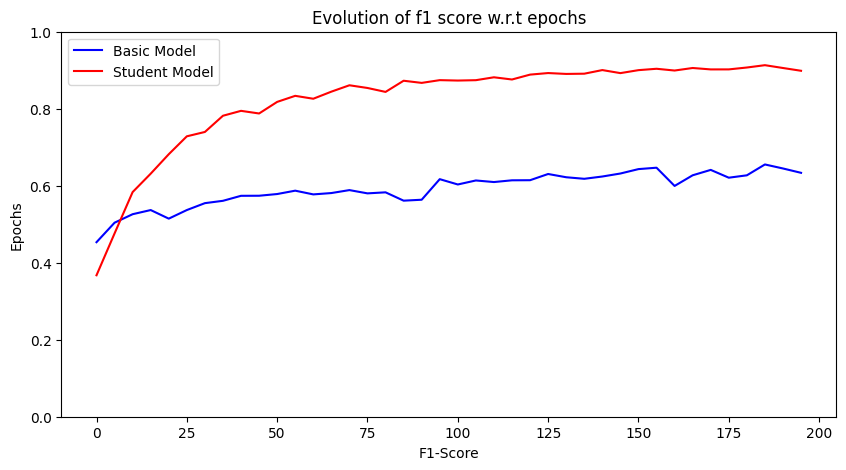

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

**With Epoch 300**

In [13]:
## Student model
# student_model = StudentModel(##### YOUR ANSWER #####).to(device)
student_model = StudentModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, 300, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7766
F1-Score: 0.3685
Epoch 00002 | Loss: 0.5696
Epoch 00003 | Loss: 0.5398
Epoch 00004 | Loss: 0.5231
Epoch 00005 | Loss: 0.5142
Epoch 00006 | Loss: 0.5056
F1-Score: 0.4770
Epoch 00007 | Loss: 0.5026
Epoch 00008 | Loss: 0.4952
Epoch 00009 | Loss: 0.4852
Epoch 00010 | Loss: 0.4820
Epoch 00011 | Loss: 0.4765
F1-Score: 0.5660
Epoch 00012 | Loss: 0.4787
Epoch 00013 | Loss: 0.4706
Epoch 00014 | Loss: 0.4590
Epoch 00015 | Loss: 0.4490
Epoch 00016 | Loss: 0.4441
F1-Score: 0.5613
Epoch 00017 | Loss: 0.4475
Epoch 00018 | Loss: 0.4385
Epoch 00019 | Loss: 0.4400
Epoch 00020 | Loss: 0.4348
Epoch 00021 | Loss: 0.4213
F1-Score: 0.6022
Epoch 00022 | Loss: 0.4123
Epoch 00023 | Loss: 0.4046
Epoch 00024 | Loss: 0.3989
Epoch 00025 | Loss: 0.3961
Epoch 00026 | Loss: 0.4055
F1-Score: 0.6661
Epoch 00027 | Loss: 0.4011
Epoch 00028 | Loss: 0.3929
Epoch 00029 | Loss: 0.3791
Epoch 00030 | Loss: 0.3672
Epoch 00031 | Loss: 0.3583
F1-Score: 0.6740
Epoch 00032 | Loss: 0.3566
Epoch 00033 | Los

In [19]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

Student Model : F1-Score on the test set: 0.9479


## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

>Answer  

1. The chosen architecture for the classification task utilizes Graph Attention Networks (GATs) which have been selected for their ability to assign varying levels of importance to nodes within the network. Unlike the basic model's GCNLayer, which treats all neighbors equally, GAT layers weigh neighbors based on the attention mechanism, enabling the model to focus on the most relevant features. This adaptability is particularly beneficial in graph data where the significance of each node's connections can vary greatly, potentially leading to more nuanced and accurate classifications.  
  
2. With the student model achieving an F1-Score of 0.9398, it has shown a remarkable performance on the PPI test set. This result is significantly closer to the state-of-the-art performance reported for the GAT model (F1-Score of 0.973). The student model's learning curve indicates a stable and consistent improvement in the ability to classify protein interactions correctly, as reflected in the plateau of the F1-Score towards the later epochs. These results are promising and suggest that the model's architecture and hyperparameters are well-tuned for the task, positioning it competitively with the leading models in the field.



**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ?
2. Are there solutions to overcome it ?
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> Answer